In [465]:
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np

## 1. Niño 3.4 index

### 1.1  Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

In [466]:
ncfile = 'NOAA_NCDC_ERSST_v3b_SST.nc'
ds = xr.open_dataset(ncfile)
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [467]:
# Read variables
time = ds['time'][:]
lat  = ds['lat'][:]                       
lon  = ds['lon'][:]
sst  = ds['sst'][:,:,:]

In [468]:
# Set up the map.
def plotmap():
    plt.figure(figsize=(15,10))
    plt.rcParams['figure.figsize'] = (15, 10)
    
    #Set the projection information
    proj = ccrs.PlateCarree(central_longitude=180)
    #Create a figure with an axes object and ass the projection to that axes.
    fig,ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    # Set X and Y axes
    ax.set_xticks([0,60,120,180,240,300,360],crs=ccrs.PlateCarree())
    ax.set_yticks([-90,-60,-30,0,30,60,90],crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both',labelsize=13)

    # Add coastlines
    ax.coastlines(zorder=10)
    
    # Add gridlines
    ax.gridlines(xlocs=np.arange(0,361,30), ylocs=np.arange(-90,91,30))
    
    return fig,ax

In [471]:
# Calculate the monthly mean SST
sstmean = np.zeros((12,89,180))
for i in range(0,12):
    month = sst.isel(time=slice(i,180,12)).values
    monthmean = np.mean(month,axis=0)
    sstmean[i,:,:] = monthmean[:,:]

In [475]:
# Select the Niño 3.4 region
# Niño 3.4 (5N-5S, 170W-120W)
region34 = sst.sel(lat=slice(-5,5)).sel(lon=slice(190,240))
#ctime = time.sel(time=slice('1982','2018'))
region34_mean = np.mean(region34,axis=(1,2))

<Figure size 864x288 with 0 Axes>

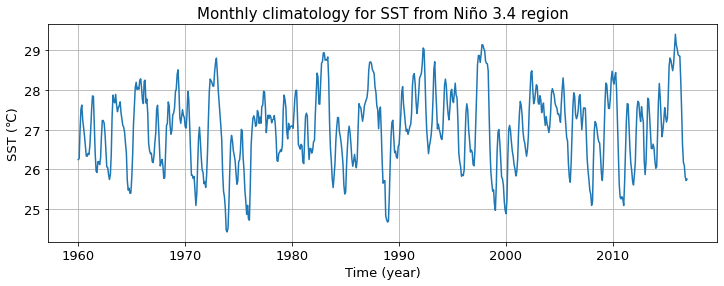

In [476]:
fig = plt.figure(figsize=(12,4))
plt.rcParams['figure.figsize'] = (12,4)

fig, ax = plt.subplots()

ax.plot(time,region34_mean)
ax.tick_params(axis='both',labelsize=13)
ax.set_xlabel('Time (year)',fontsize=13)
ax.set_ylabel('SST (℃)',fontsize=13)
ax.set_title('Monthly climatology for SST from Niño 3.4 region',fontsize=15)
ax.grid()

plt.show()

In [477]:
# Calculate the monthly mean SST of Niño 3.4 region
region34_m_mean = np.zeros(12)
for i in range(0,12):
    region34_m_mean[i] = np.mean(region34_mean.isel(time=np.arange(i,180,12)).values)

# Calculate the anomalies
# Subtract the monthly mean SST to detrend the seasonal variation
region34_anoma = np.zeros(57*12)
for i in range(0,57*12):
    k = i % 12
    region34_anoma[i] = region34_mean.values[i] - region34_m_mean[k]

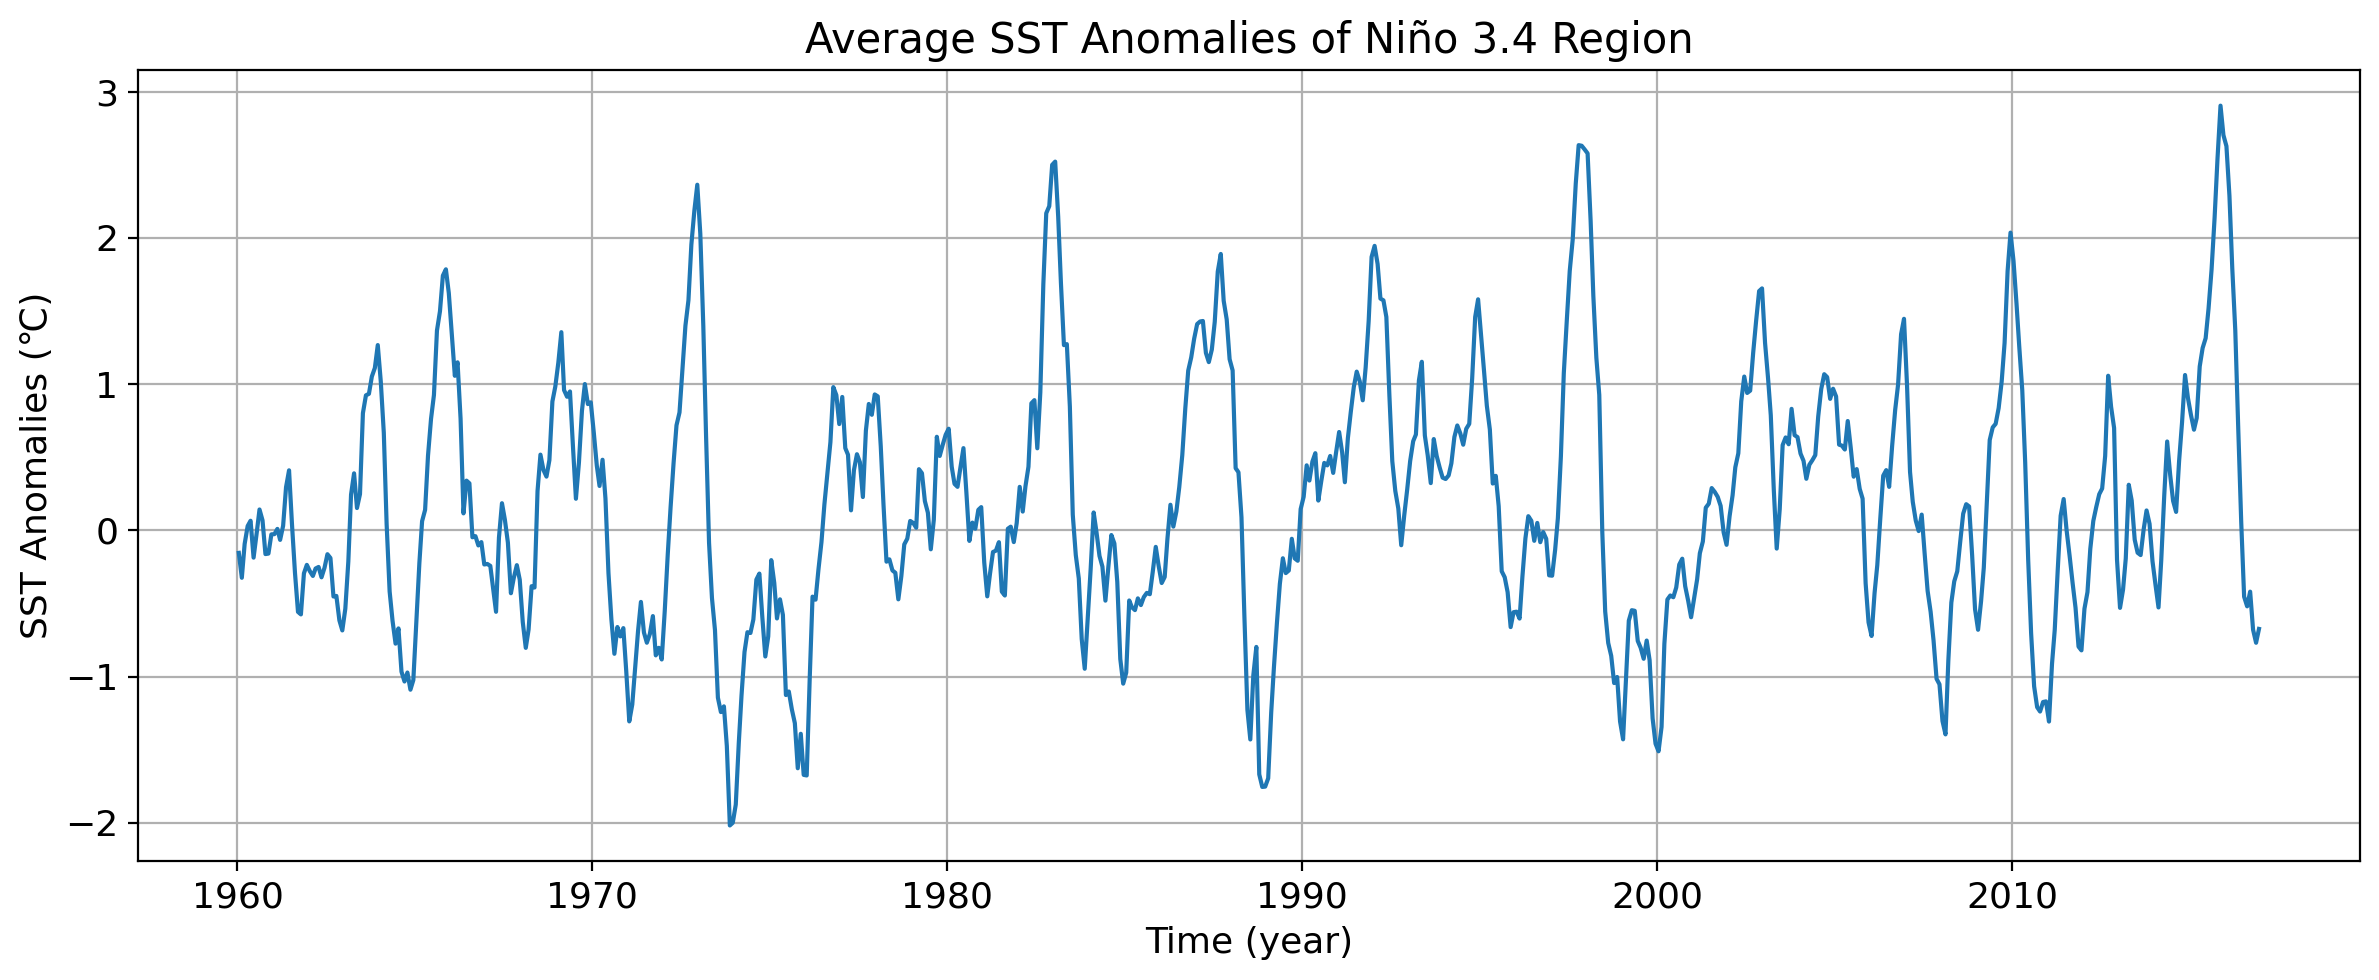

In [478]:
fig, ax = plt.subplots(figsize=(12,5),dpi=200)

ax.plot(time,region34_anoma)
ax.tick_params(axis='both',labelsize=13)
#ax.set_ylim(-3.5,3.5)
ax.set_xlabel('Time (year)',fontsize=13)
ax.set_ylabel('SST Anomalies (℃)',fontsize=13)
ax.set_title('Average SST Anomalies of Niño 3.4 Region',fontsize=15)
ax.grid()
plt.tight_layout()
plt.show()

### 1.2 Visualize the computed Niño 3.4.

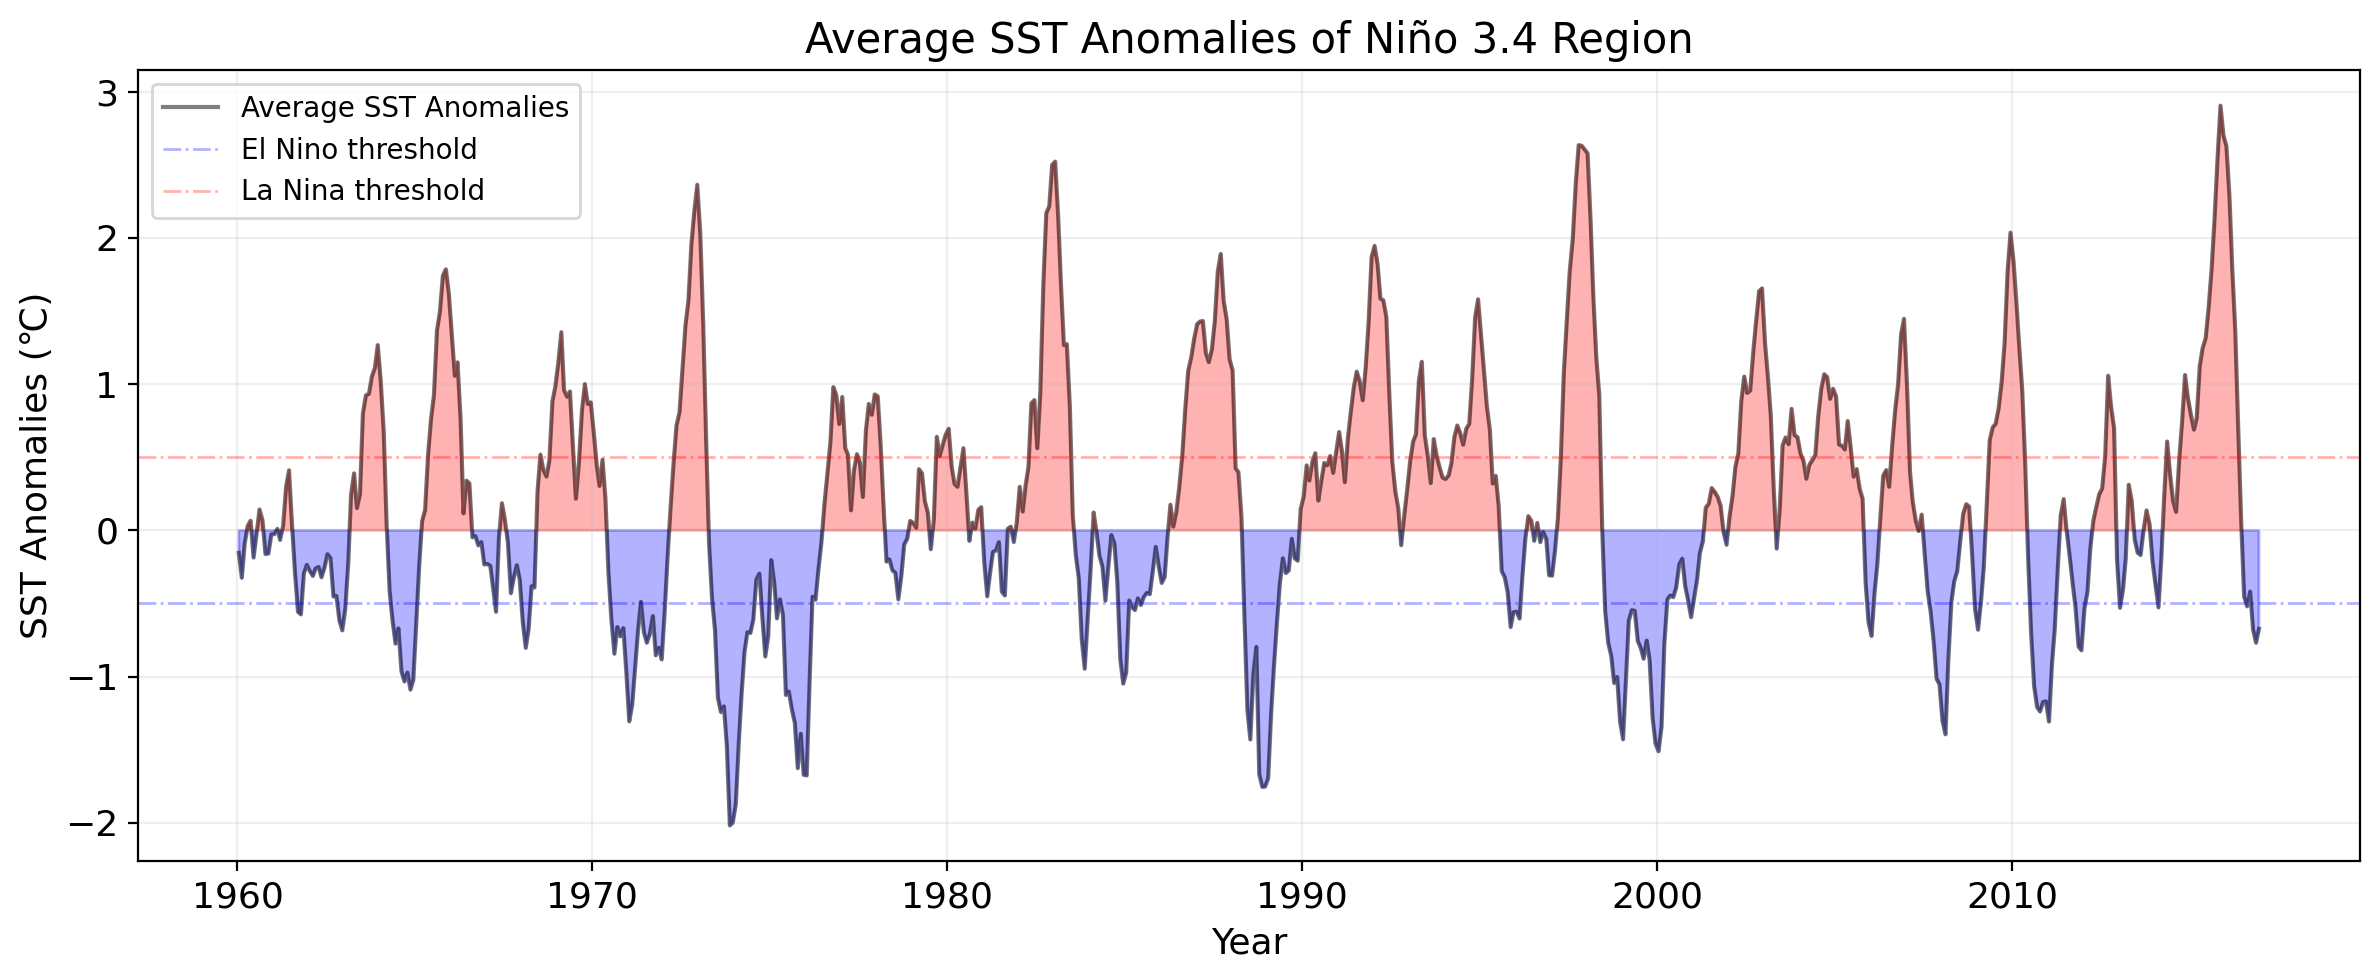

In [479]:
fig, ax = plt.subplots(figsize=(12,5),dpi=200)

ax.plot(time,region34_anoma, label = 'Average SST Anomalies',color='black', alpha=0.5)
ax.fill_between(time, region34_anoma, where=(region34_anoma > 0), interpolate=True, color='red', alpha=0.3)
ax.fill_between(time, region34_anoma, where=(region34_anoma < 0), interpolate=True, color='blue', alpha=0.3)

ax.axhline(y=-0.5, color='blue', linestyle='-.', label='El Nino threshold', linewidth=1, alpha=0.3)
ax.axhline(y=0.5, color='red', linestyle='-.',  label='La Nina threshold', linewidth=1, alpha=0.3)

ax.tick_params(axis='both',labelsize=13)
#ax.set_ylim(-3.5,3.5)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('SST Anomalies (℃)',fontsize=13)
ax.set_title('Average SST Anomalies of Niño 3.4 Region',fontsize=15)
ax.grid(alpha=0.2)

plt.tight_layout()
plt.legend()
plt.show()

## 2. Earth’s energy budget

### 2.1 Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux.

In [480]:
ncfile2 = 'CERES_EBAF-TOA_200003-201701.nc'
ds2 = xr.open_dataset(ncfile2)
ds2

<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 ...
    toa_lw_all_mon               (time, lat, lon) float32 ...
    toa_net_all_mon              (time, lat, lon) float32 ...
    toa_sw_clr_mon               (time, lat, lon) float32 ...
    toa_lw_clr_mon               (time, lat, lon) float32 ...
    toa_net_clr_mon              (time, lat, lon) float32 ...
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 ...
    solar_mon                    (time, lat, lon) float32 ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 ...
    cldtemp_total_daynight_mon   (time, lat, lon) float32 ...
    cldtau_total_day_mon         (time, lat, lon) float32 ...
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

In [481]:
lw = ds2['toa_lw_all_mon']
sw = ds2['toa_sw_all_mon']
rad = ds2['solar_mon']
net = ds2['toa_net_all_mon']

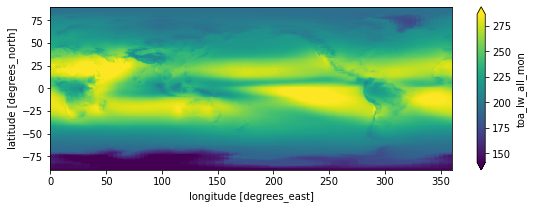

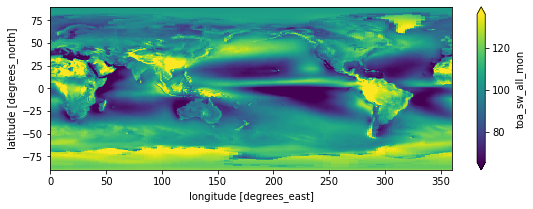

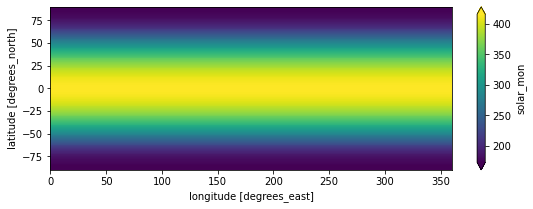

In [483]:
# Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. 
lw.mean(dim='time').plot(size=3,robust=True)
sw.mean(dim='time').plot(size=3,robust=True)
rad.mean(dim='time').plot(size=3,robust=True)

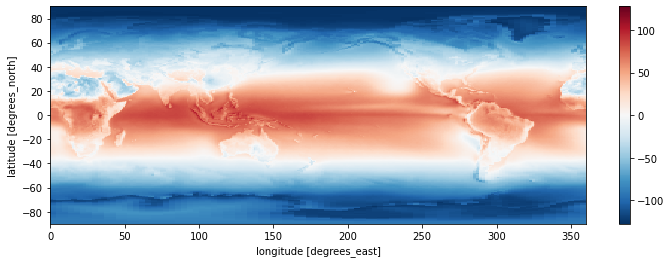

In [484]:
# Visualise the three variables above
(rad.mean(dim='time')-lw.mean(dim='time')-sw.mean(dim='time')).plot()

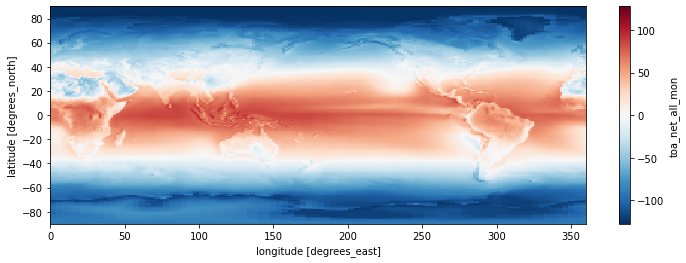

In [485]:
# Visualise the TOA net flux
net.mean(dim='time').plot()

By Comparing the figure of the above two flux, we can know that the incoming solar radiation substract the outcoming longwave and shortwave radiation equals to the net TOA flux.

### 2.2 Calculate and verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above.

In [486]:
in_solar = rad.mean()
out_lw = lw.mean()
out_sw = sw.mean()
print("incoming solar: ", in_solar.values)
print("outgoing longwave: ", out_lw.values)
print("outgoing shortwave: ", out_sw.values)

incoming solar:  298.33038
outgoing longwave:  224.7552
outgoing shortwave:  102.30436


In [487]:
(in_solar.values-out_lw.values-out_sw.values)


-28.72918

In [488]:
net.mean().values

array(-28.729034, dtype=float32)

### 2.3 Calculate and plot the total amount of net radiation in each 1-degree latitude band. Label with correct units.

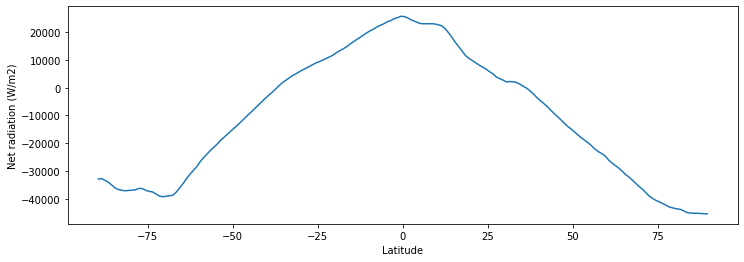

In [489]:
net.sum(dim='lon').mean(dim='time').plot()
plt.xlabel('Latitude')
plt.ylabel('Net radiation (W/m2)')
plt.show()

### 2.4 Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions.



In [490]:
cloud_frac = ds2['cldarea_total_daynight_mon']

In [491]:
low_sw_mean = sw.where(cloud_frac <= 25).mean(dim='time')
high_sw_mean = sw.where(cloud_frac >= 75).mean(dim='time')

low_lw_mean = lw.where(cloud_frac <= 25).mean(dim='time')
high_lw_mean = lw.where(cloud_frac >= 75).mean(dim='time')

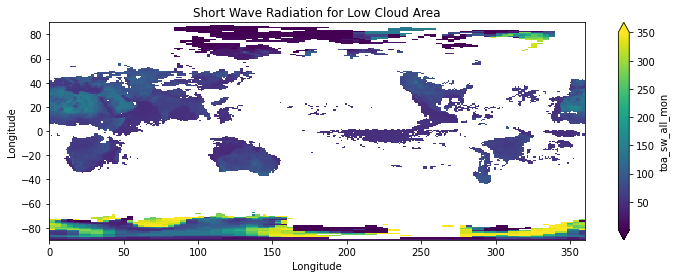

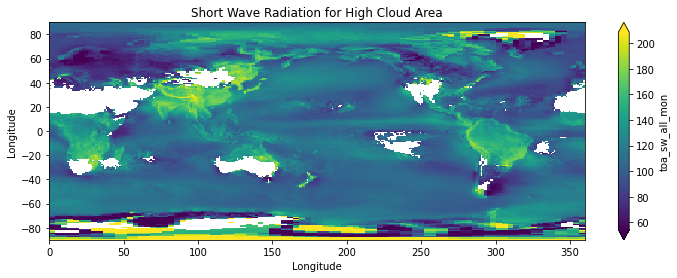

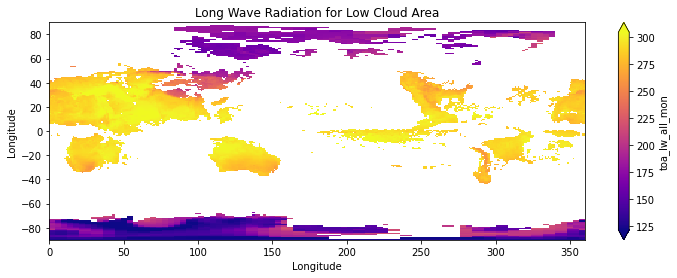

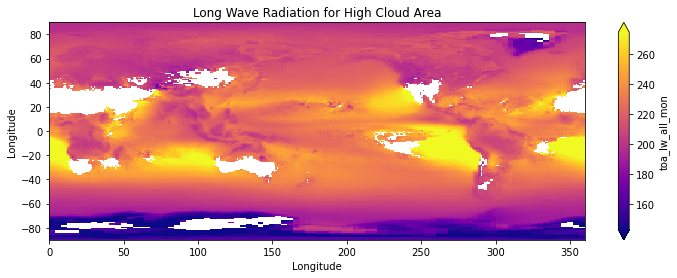

In [492]:
low_sw_mean.plot(cmap='viridis',size=4,robust=True)
plt.title('Short Wave Radiation for Low Cloud Area')
plt.xlabel('Longitude')
plt.ylabel('Longitude')
plt.show()

high_sw_mean.plot(cmap='viridis',size=4,robust=True)
plt.title('Short Wave Radiation for High Cloud Area')
plt.xlabel('Longitude')
plt.ylabel('Longitude')
plt.show()

low_lw_mean.plot(cmap='plasma',size=4,robust=True)
plt.title('Long Wave Radiation for Low Cloud Area')
plt.xlabel('Longitude')
plt.ylabel('Longitude')
plt.show()

high_lw_mean.plot(cmap='plasma',size=4,robust=True)
plt.title('Long Wave Radiation for High Cloud Area')
plt.xlabel('Longitude')
plt.ylabel('Longitude')
plt.show()

### 2.5 Calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions. What is the overall effect of clouds on shortwave and longwave radiation?



In [493]:
global_low_sw_mean = low_sw_mean.mean(dim=['lat','lon'])
global_high_sw_mean = high_sw_mean.mean(dim=['lat','lon'])

global_low_lw_mean = low_lw_mean.mean(dim=['lat','lon'])
global_high_lw_mean = high_lw_mean.mean(dim=['lat','lon'])

In [494]:
# Print results
print("Global Mean Shortwave Radiation in Low Cloud Regions:", global_low_sw_mean.values)
print("Global Mean Shortwave Radiation in High Cloud Regions:", global_high_sw_mean.values)

print("Global Mean Longwave Radiation in Low Cloud Regions:", global_low_lw_mean.values)
print("Global Mean Longwave Radiation in High Cloud Regions:", global_high_lw_mean.values)


Global Mean Shortwave Radiation in Low Cloud Regions: 88.81645
Global Mean Shortwave Radiation in High Cloud Regions: 114.74328
Global Mean Longwave Radiation in Low Cloud Regions: 233.06702
Global Mean Longwave Radiation in High Cloud Regions: 215.37349


Based on the result, the high cloud tends to lead the increasing shortwave radiation and lower the longwave radiation.

## 3. Explore a netCDF dataset

The NetCDF dataset I chose is ERA5 reanalysis data, which contains surface 2-meter temperature and 10-meter U/V speed monthly mean from 2017 to 2021. I only use the temperature variable to do some analysis below:

### 3.1 Plot a time series of a certain variable with monthly seasonal cycle removed.

In [495]:
ds3 = xr.open_dataset('/Users/xujiayu/Desktop/Course/RS/Kuangdong/monthly17-21.nc')
ds3

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1801, time: 60)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2021-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-24 17:12:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [337]:
temp = ds3['t2m'] # 2m temperature

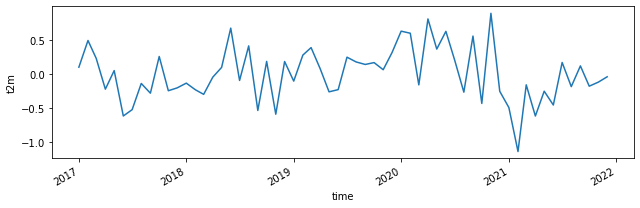

In [496]:
# time series of temperature
time_ser = temp.mean(dim=['latitude','longitude'])

# monthly seasonal cycle
m_season = temp.groupby('time.month').mean(dim='time').mean(['latitude','longitude'])

# removed the seasonal cycle
(time_ser - np.tile(m_season.values,5)).plot(size=3)
plt.tight_layout()
plt.show()


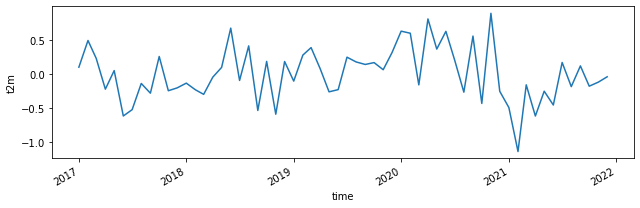

In [497]:
# removed the seasonal cycle
(time_ser - np.tile(m_season.values,5)).plot(size=3)
plt.tight_layout()
plt.show()

### 3.2 Make 5 different plots using the dataset.

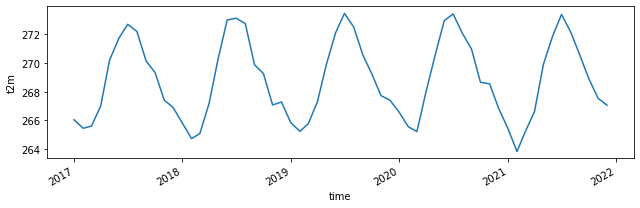

In [453]:
# 1. Time series of mean temperature
time_ser.plot(size=3)
plt.tight_layout()
plt.show()

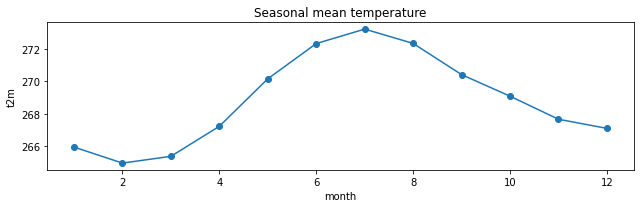

In [454]:
# 2. Seasonal and annual mean of temperature
m_season.plot(marker='o',size=3)
plt.title('Seasonal mean temperature')
plt.tight_layout()
plt.show()

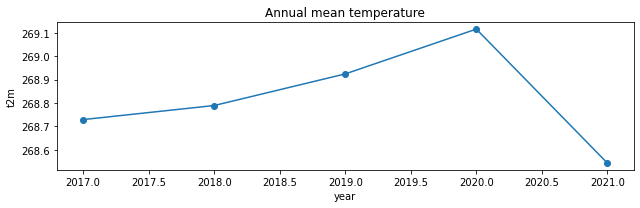

In [455]:
ann_mean = temp.groupby('time.year').mean(dim='time').mean(dim = ['latitude','longitude'])
ann_mean.plot(marker='o',size=3)
plt.title('Annual mean temperature')
plt.tight_layout()
plt.show()

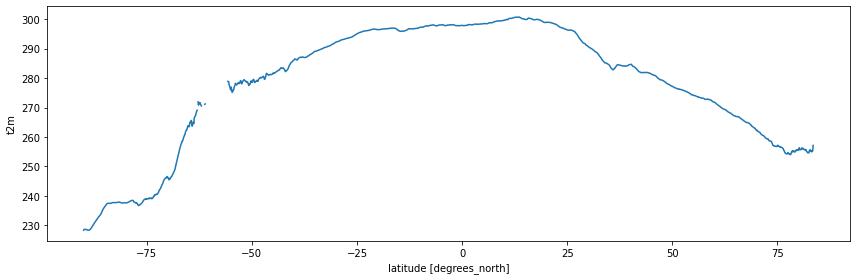

In [460]:
# 3. Time series of mean temperature in different latitude/longitude direction
temp.mean(dim=['longitude','time']).plot()
plt.tight_layout()
plt.show()

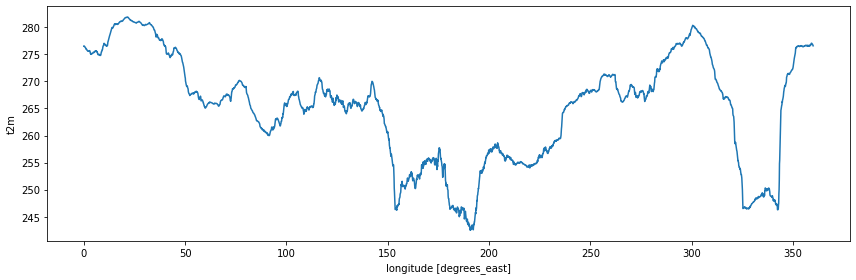

In [459]:
temp.mean(dim=['latitude','time']).plot()
plt.tight_layout()
plt.show()

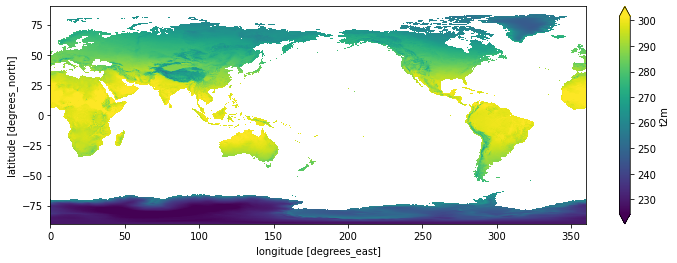

In [463]:
# 4. Mean temperature during the 5 years
temp.mean(dim='time').plot(robust=True)

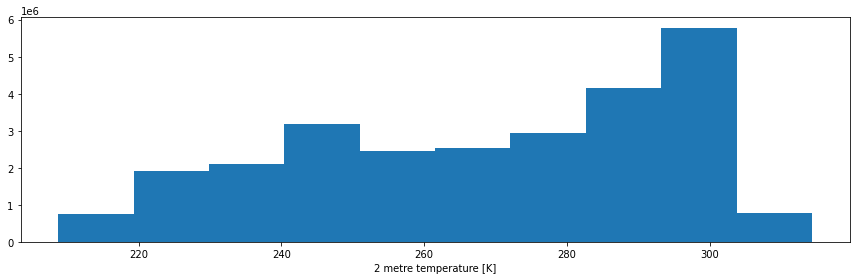

In [464]:
# 5. Histogram of mean temperature over 5 years
temp.groupby('time.month').mean().plot()
plt.tight_layout()
plt.show()